# SARIMA Model for Forecasting Bitcoin Transaction Fees (Next 24 Hours)

This notebook builds and evaluates a SARIMA model to forecast the **Bitcoin transaction fee** over the **next 24 hours** , using **15-minute interval data** resampled from the raw mempool dataset.

### Why SARIMA?

During exploratory data analysis (EDA), we identified:
- **Daily seasonality patterns** in transaction fees (24-hour cycle),
- **Strong autocorrelation**, indicating temporal dependence.

Given these findings, the SARIMA model is an appropriate choice as it can model:
- Autoregressive and moving average components,
- **Seasonal effects**, such as daily cyclic behavior.

This notebook walks through the full modeling pipeline using SARIMA.


In [2]:
from sktime.forecasting.model_selection import (ExpandingWindowSplitter, SlidingWindowSplitter, temporal_train_test_split)
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.arima import AutoARIMA, ARIMA
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error, mean_squared_error, mean_absolute_error
from sktime.forecasting.model_evaluation import evaluate
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
import numpy as np
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

## 1. Data Loading

We begin by loading the preprocessed dataset specifically prepared for SARIMA and HWES models.


In [3]:
df = pd.read_parquet('../data/processed/preprocessed_sarima_15min.parquet')

df.head()

,mempool_blocks_blockSize,mempool_blocks_blockVSize,mempool_blocks_nTx,mempool_blocks_totalFees,mempool_blocks_medianFee,recommended_fee_fastestFee,recommended_fee_halfHourFee,recommended_fee_hourFee,recommended_fee_economyFee,recommended_fee_minimumFee,...,mempool_fee_histogram_bin_70_75,mempool_fee_histogram_bin_75_80,mempool_fee_histogram_bin_80_85,mempool_fee_histogram_bin_85_90,mempool_fee_histogram_bin_90_95,mempool_fee_histogram_bin_95_100,mempool_fee_histogram_bin_100_150,mempool_fee_histogram_bin_150_200,mempool_fee_histogram_bin_200_250,mempool_fee_histogram_bin_250_300
timestamp,,,,,,,,,,,,,,,,,,,,,
2025-03-05 02:00:00,2.131827e+06,997874.250000,1030.000000,2.077770e+06,1.300139,2.000000,2.000000,2.000000,2.000000,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2025-03-05 02:15:00,1.801526e+06,997925.916667,2627.000000,3.407913e+06,2.473960,3.000000,2.666667,2.666667,2.666667,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2025-03-05 02:30:00,2.055350e+06,997965.916667,922.000000,1.855358e+06,1.355898,2.000000,2.000000,2.000000,2.000000,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2025-03-05 02:45:00,2.006800e+06,997970.083333,1296.666667,2.167251e+06,1.536092,2.333333,2.333333,2.333333,2.333333,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2025-03-05 03:00:00,1.773658e+06,997960.333333,2725.333333,3.462741e+06,2.467659,3.333333,3.000000,3.000000,3.000000,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# 2. Autocorrelation, Partial Autocorrelation Analysis and Stationarity Check (ADF Test)

To determine the appropriate AR (autoregressive) and MA (moving average) orders, we examine the **Autocorrelation Function (ACF)** and **Partial Autocorrelation Function (PACF)** of the target variable. Before fitting a SARIMA model, we need to verify if the time series is **stationary** — a key assumption for ARIMA-family models. We use the **Augmented Dickey-Fuller (ADF) test**, which tests the null hypothesis that the time series has a unit root (i.e., is non-stationary).

(3968,)

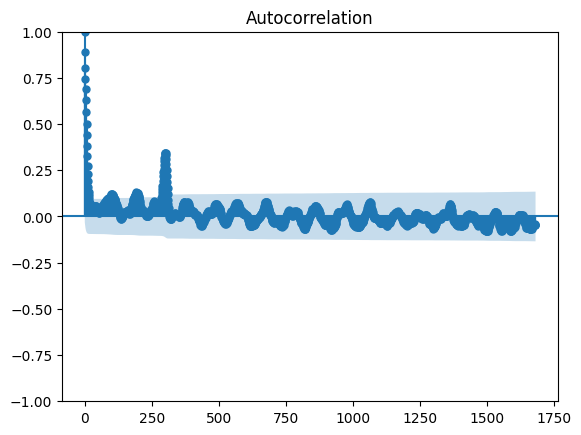

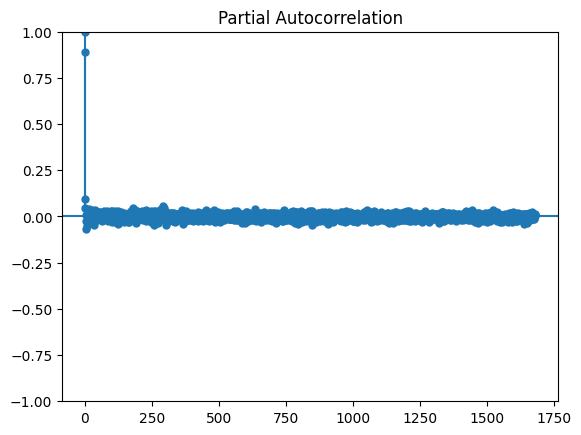

In [4]:
y = df["recommended_fee_fastestFee"]
plot_acf(y, lags=1680)   
plot_pacf(y, lags=1680)
y.shape

In [5]:
adfuller(y)[1]

2.856371654220831e-20

The PACF cuts off at lag 1 and the ACF shows a significant lag-1 with slow decay, suggesting an ARIMA(1, 0, 1) structure. Clear seasonal spikes at lag 96 in the ACF indicate a seasonal pattern, so we set the seasonal order to (1, 0, 1, 96)

## 3. Train-Test Splits using Expanding and Sliding Window

### 3.1.1 Expanding Window Forecasting - Daily

Use expanding window to evaluate SARIMA performance across different time periods (7-day initial window, 1-day forecast).

In [12]:
warnings.filterwarnings("ignore", category=FutureWarning)

# Define forecast horizon: next 96 steps (15min × 96 = 1 day)
fh = list(range(1, 97))

# Create expanding window splitter
expanding_cv = ExpandingWindowSplitter(
    initial_window=96 * 7,   # 1 week of training data
    step_length=96,          # move window forward by 1 day
    fh=fh
)

# Initialize lists to store errors
mse_list = []
mae_list = []

# Loop through each split and fit SARIMA model
for i, (train_idx, test_idx) in enumerate(expanding_cv.split(y)):
    y_train = y.iloc[train_idx]
    y_test = y.iloc[test_idx]

    # Log transform the training data
    y_train_log = np.log1p(y_train)

    # Initialize ARIMA forecaster
    forecaster = ARIMA(order=(1, 0, 1), seasonal_order=(1, 0, 1, 96))

    # Fit model
    forecaster.fit(y_train_log)

    # Forecast next 96 steps
    y_pred_log = forecaster.predict(fh=fh)
    y_pred = np.expm1(y_pred_log)  # Inverse log transform

    # Compute and store errors
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    mse_list.append(mse)
    mae_list.append(mae)

    print(f"Fold {i+1} — MSE: {mse:.2f}, MAE: {mae:.2f}")

# Show average performance across all splits
print(f"\nAverage MSE: {np.mean(mse_list):.2f}")
print(f"Average MAE: {np.mean(mae_list):.2f}")

/Users/liuyajing/miniforge3/envs/sarima-env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/liuyajing/miniforge3/envs/sarima-env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/liuyajing/miniforge3/envs/sarima-env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Fold 1 — MSE: 0.65, MAE: 0.67


/Users/liuyajing/miniforge3/envs/sarima-env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/liuyajing/miniforge3/envs/sarima-env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Fold 2 — MSE: 3.09, MAE: 1.16


/Users/liuyajing/miniforge3/envs/sarima-env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/liuyajing/miniforge3/envs/sarima-env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Fold 3 — MSE: 1.55, MAE: 0.97


/Users/liuyajing/miniforge3/envs/sarima-env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/liuyajing/miniforge3/envs/sarima-env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Fold 4 — MSE: 4.43, MAE: 1.47


/Users/liuyajing/miniforge3/envs/sarima-env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/liuyajing/miniforge3/envs/sarima-env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Fold 5 — MSE: 1.11, MAE: 0.91


/Users/liuyajing/miniforge3/envs/sarima-env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/liuyajing/miniforge3/envs/sarima-env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Fold 6 — MSE: 0.86, MAE: 0.77


/Users/liuyajing/miniforge3/envs/sarima-env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/liuyajing/miniforge3/envs/sarima-env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Fold 7 — MSE: 0.72, MAE: 0.73


/Users/liuyajing/miniforge3/envs/sarima-env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/liuyajing/miniforge3/envs/sarima-env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Fold 8 — MSE: 1.71, MAE: 0.95


/Users/liuyajing/miniforge3/envs/sarima-env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/liuyajing/miniforge3/envs/sarima-env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Fold 9 — MSE: 2.69, MAE: 1.20


/Users/liuyajing/miniforge3/envs/sarima-env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/liuyajing/miniforge3/envs/sarima-env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Fold 10 — MSE: 1.09, MAE: 0.85


/Users/liuyajing/miniforge3/envs/sarima-env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/liuyajing/miniforge3/envs/sarima-env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Fold 11 — MSE: 52.05, MAE: 3.34


/Users/liuyajing/miniforge3/envs/sarima-env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/liuyajing/miniforge3/envs/sarima-env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Fold 12 — MSE: 0.90, MAE: 0.57


/Users/liuyajing/miniforge3/envs/sarima-env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/liuyajing/miniforge3/envs/sarima-env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Fold 13 — MSE: 2.33, MAE: 1.10


/Users/liuyajing/miniforge3/envs/sarima-env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/liuyajing/miniforge3/envs/sarima-env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Fold 14 — MSE: 106.98, MAE: 5.35


/Users/liuyajing/miniforge3/envs/sarima-env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/liuyajing/miniforge3/envs/sarima-env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Fold 15 — MSE: 4.02, MAE: 1.26


/Users/liuyajing/miniforge3/envs/sarima-env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/liuyajing/miniforge3/envs/sarima-env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Fold 16 — MSE: 0.65, MAE: 0.70


/Users/liuyajing/miniforge3/envs/sarima-env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/liuyajing/miniforge3/envs/sarima-env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Fold 17 — MSE: 2.35, MAE: 1.13


/Users/liuyajing/miniforge3/envs/sarima-env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/liuyajing/miniforge3/envs/sarima-env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Fold 18 — MSE: 0.97, MAE: 0.90


/Users/liuyajing/miniforge3/envs/sarima-env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/liuyajing/miniforge3/envs/sarima-env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Fold 19 — MSE: 1.66, MAE: 1.10


/Users/liuyajing/miniforge3/envs/sarima-env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/liuyajing/miniforge3/envs/sarima-env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Fold 20 — MSE: 1.82, MAE: 1.15


/Users/liuyajing/miniforge3/envs/sarima-env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/liuyajing/miniforge3/envs/sarima-env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Fold 21 — MSE: 1.20, MAE: 0.92


/Users/liuyajing/miniforge3/envs/sarima-env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/liuyajing/miniforge3/envs/sarima-env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Fold 22 — MSE: 1.63, MAE: 1.07


/Users/liuyajing/miniforge3/envs/sarima-env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/liuyajing/miniforge3/envs/sarima-env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Fold 23 — MSE: 1.39, MAE: 0.95


/Users/liuyajing/miniforge3/envs/sarima-env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/liuyajing/miniforge3/envs/sarima-env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Fold 24 — MSE: 1.97, MAE: 1.26


/Users/liuyajing/miniforge3/envs/sarima-env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/liuyajing/miniforge3/envs/sarima-env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Fold 25 — MSE: 1.75, MAE: 1.15


/Users/liuyajing/miniforge3/envs/sarima-env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/liuyajing/miniforge3/envs/sarima-env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Fold 26 — MSE: 2.00, MAE: 1.27


/Users/liuyajing/miniforge3/envs/sarima-env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/liuyajing/miniforge3/envs/sarima-env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Fold 27 — MSE: 2.30, MAE: 1.19


/Users/liuyajing/miniforge3/envs/sarima-env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/liuyajing/miniforge3/envs/sarima-env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Fold 28 — MSE: 2.48, MAE: 1.18


/Users/liuyajing/miniforge3/envs/sarima-env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/liuyajing/miniforge3/envs/sarima-env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Fold 29 — MSE: 1.42, MAE: 0.99


/Users/liuyajing/miniforge3/envs/sarima-env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/liuyajing/miniforge3/envs/sarima-env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Fold 30 — MSE: 1.97, MAE: 1.18


/Users/liuyajing/miniforge3/envs/sarima-env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/liuyajing/miniforge3/envs/sarima-env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Fold 31 — MSE: 0.94, MAE: 0.80


/Users/liuyajing/miniforge3/envs/sarima-env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/liuyajing/miniforge3/envs/sarima-env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Fold 32 — MSE: 1.07, MAE: 0.85


/Users/liuyajing/miniforge3/envs/sarima-env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/liuyajing/miniforge3/envs/sarima-env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Fold 33 — MSE: 1.37, MAE: 1.01
Fold 34 — MSE: 1.80, MAE: 0.97

Average MSE: 6.32
Average MAE: 1.21


/Users/liuyajing/miniforge3/envs/sarima-env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


**Expanding Window Forecasting - Daily Insight**

We evaluated SARIMA using an **expanding window** strategy, starting with 7 days of training data and incrementally expanding the window, testing on the next day.  
This approach simulates a real-world deployment scenario where more data becomes available over time.

- **Average MSE:** 6.32  
- **Average MAE:** 1.21  
- **Observation:**  
  The model maintained stable performance across most folds.  
  However, folds containing extreme fee spikes (e.g., Fold 11 & 14) saw significant error increases, highlighting SARIMA's limitations under volatile conditions.


### 3.1.2 Expanding Window Forecasting - Weekly

Use expanding window to evaluate SARIMA performance on a weekly basis (7-day initial window, 7-day forecast horizon), simulating generalization across multiple weekly periods.


In [ ]:
# Define forecast horizon: next 7 days (15min × 96 × 7 = 672 steps)
fh = list(range(1, 96 * 7 + 1))

# Create expanding window splitter for weekly forecasting
expanding_cv_weekly = ExpandingWindowSplitter(
    initial_window=96 * 7,   # 1 week of training
    step_length=96 * 7,      # move window by 1 week
    fh=fh
)

# Initialize error containers
mse_list_weekly = []
mae_list_weekly = []

# Run cross-validation
for i, (train_idx, test_idx) in enumerate(expanding_cv_weekly.split(y)):
    y_train = y.iloc[train_idx]
    y_test = y.iloc[test_idx]

    y_train_log = np.log1p(y_train)

    forecaster = ARIMA(order=(1, 0, 1), seasonal_order=(1, 0, 1, 96))
    forecaster.fit(y_train_log)

    y_pred_log = forecaster.predict(fh=fh)
    y_pred = np.expm1(y_pred_log)

    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    mse_list_weekly.append(mse)
    mae_list_weekly.append(mae)

    print(f"Week {i+1} — MSE: {mse:.2f}, MAE: {mae:.2f}")

print(f"\nAverage Weekly MSE: {np.mean(mse_list_weekly):.2f}")
print(f"Average Weekly MAE: {np.mean(mae_list_weekly):.2f}")


/Users/liuyajing/miniforge3/envs/sarima-env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/liuyajing/miniforge3/envs/sarima-env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/liuyajing/miniforge3/envs/sarima-env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Week 1 — MSE: 1.85, MAE: 0.97


/Users/liuyajing/miniforge3/envs/sarima-env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/liuyajing/miniforge3/envs/sarima-env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Week 2 — MSE: 24.53, MAE: 1.95


/Users/liuyajing/miniforge3/envs/sarima-env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/liuyajing/miniforge3/envs/sarima-env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Week 3 — MSE: 1.94, MAE: 1.08
Week 4 — MSE: 2.00, MAE: 1.19

Average Weekly MSE: 7.58
Average Weekly MAE: 1.30


/Users/liuyajing/miniforge3/envs/sarima-env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


### Expanding Window Forecasting - Weekly Insight 

We evaluated SARIMA using an **expanding window** strategy, starting with 7 days of training data and expanding the window week by week, testing on the next 7 days.  
This setup simulates model performance in weekly deployment scenarios, testing generalization over longer time horizons.

- **Average Weekly MSE**: 7.58  
- **Average Weekly MAE**: 1.30  
- **Observation**:  
  The model showed consistent performance across most weeks.  
  However, Week 2 saw a large performance drop due to a fee spike, again revealing SARIMA's limitations in highly volatile periods.


### 3.2.1 Sliding Window Forecasting - Daily

To further assess temporal stability and generalization, we apply a **sliding window** strategy using a fixed 7-day training window and 1-day test window (96 × 15-minute intervals).  
This allows us to evaluate SARIMA performance across multiple time segments without expanding the training data size.

In [ ]:
# Define forecast horizon: next 96 steps (15min × 96 = 1 day)
fh = list(range(1, 97))

# Create sliding window splitter
sliding_cv = SlidingWindowSplitter(
    window_length=96 * 7,  # fixed 7-day training window
    step_length=96,        # move forward by 1 day
    fh=fh
)

# Initialize lists to store errors
mse_list = []
mae_list = []

# Loop through each split and fit SARIMA model
for i, (train_idx, test_idx) in enumerate(sliding_cv.split(y)):
    y_train = y.iloc[train_idx]
    y_test = y.iloc[test_idx]

    # Log transform the training data
    y_train_log = np.log1p(y_train)

    # Initialize ARIMA forecaster
    forecaster = ARIMA(order=(1, 0, 1), seasonal_order=(1, 0, 1, 96))

    # Fit model
    forecaster.fit(y_train_log)

    # Forecast next 96 steps
    y_pred_log = forecaster.predict(fh=fh)
    y_pred = np.expm1(y_pred_log)

    # Compute and store errors
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    mse_list.append(mse)
    mae_list.append(mae)

    print(f"Fold {i+1} — MSE: {mse:.2f}, MAE: {mae:.2f}")

# Show average performance across all splits
print(f"\nAverage MSE: {np.mean(mse_list):.2f}")
print(f"Average MAE: {np.mean(mae_list):.2f}")


/Users/liuyajing/miniforge3/envs/sarima-env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/liuyajing/miniforge3/envs/sarima-env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/liuyajing/miniforge3/envs/sarima-env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Fold 1 — MSE: 0.65, MAE: 0.67


/Users/liuyajing/miniforge3/envs/sarima-env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/liuyajing/miniforge3/envs/sarima-env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Fold 2 — MSE: 3.16, MAE: 1.17


/Users/liuyajing/miniforge3/envs/sarima-env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/liuyajing/miniforge3/envs/sarima-env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Fold 3 — MSE: 1.70, MAE: 1.04


/Users/liuyajing/miniforge3/envs/sarima-env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/liuyajing/miniforge3/envs/sarima-env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Fold 4 — MSE: 4.97, MAE: 1.52


/Users/liuyajing/miniforge3/envs/sarima-env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/liuyajing/miniforge3/envs/sarima-env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Fold 5 — MSE: 1.14, MAE: 0.92


/Users/liuyajing/miniforge3/envs/sarima-env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/liuyajing/miniforge3/envs/sarima-env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Fold 6 — MSE: 0.80, MAE: 0.76


/Users/liuyajing/miniforge3/envs/sarima-env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/liuyajing/miniforge3/envs/sarima-env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Fold 7 — MSE: 0.76, MAE: 0.75


/Users/liuyajing/miniforge3/envs/sarima-env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/liuyajing/miniforge3/envs/sarima-env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Fold 8 — MSE: 1.75, MAE: 0.97


/Users/liuyajing/miniforge3/envs/sarima-env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/liuyajing/miniforge3/envs/sarima-env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Fold 9 — MSE: 3.16, MAE: 1.36


/Users/liuyajing/miniforge3/envs/sarima-env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/liuyajing/miniforge3/envs/sarima-env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Fold 10 — MSE: 1.13, MAE: 0.87


/Users/liuyajing/miniforge3/envs/sarima-env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/liuyajing/miniforge3/envs/sarima-env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Fold 11 — MSE: 52.61, MAE: 3.38


/Users/liuyajing/miniforge3/envs/sarima-env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/liuyajing/miniforge3/envs/sarima-env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Fold 12 — MSE: 0.91, MAE: 0.61


/Users/liuyajing/miniforge3/envs/sarima-env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/liuyajing/miniforge3/envs/sarima-env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Fold 13 — MSE: 2.37, MAE: 1.12


/Users/liuyajing/miniforge3/envs/sarima-env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/liuyajing/miniforge3/envs/sarima-env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Fold 14 — MSE: 105.00, MAE: 5.36


/Users/liuyajing/miniforge3/envs/sarima-env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/liuyajing/miniforge3/envs/sarima-env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Fold 15 — MSE: 3.86, MAE: 1.37


/Users/liuyajing/miniforge3/envs/sarima-env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/liuyajing/miniforge3/envs/sarima-env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Fold 16 — MSE: 1.02, MAE: 0.89


/Users/liuyajing/miniforge3/envs/sarima-env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/liuyajing/miniforge3/envs/sarima-env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Fold 17 — MSE: 2.23, MAE: 1.18


/Users/liuyajing/miniforge3/envs/sarima-env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/liuyajing/miniforge3/envs/sarima-env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Fold 18 — MSE: 1.51, MAE: 1.13


/Users/liuyajing/miniforge3/envs/sarima-env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/liuyajing/miniforge3/envs/sarima-env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Fold 19 — MSE: 2.06, MAE: 1.25


/Users/liuyajing/miniforge3/envs/sarima-env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/liuyajing/miniforge3/envs/sarima-env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Fold 20 — MSE: 1.82, MAE: 1.12


/Users/liuyajing/miniforge3/envs/sarima-env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/liuyajing/miniforge3/envs/sarima-env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Fold 21 — MSE: 1.06, MAE: 0.87


/Users/liuyajing/miniforge3/envs/sarima-env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/liuyajing/miniforge3/envs/sarima-env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Fold 22 — MSE: 1.32, MAE: 0.91


/Users/liuyajing/miniforge3/envs/sarima-env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/liuyajing/miniforge3/envs/sarima-env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Fold 23 — MSE: 1.32, MAE: 0.87


/Users/liuyajing/miniforge3/envs/sarima-env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/liuyajing/miniforge3/envs/sarima-env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Fold 24 — MSE: 1.32, MAE: 0.96


/Users/liuyajing/miniforge3/envs/sarima-env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/liuyajing/miniforge3/envs/sarima-env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Fold 25 — MSE: 1.25, MAE: 0.92


/Users/liuyajing/miniforge3/envs/sarima-env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/liuyajing/miniforge3/envs/sarima-env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Fold 26 — MSE: 1.04, MAE: 0.87


/Users/liuyajing/miniforge3/envs/sarima-env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/liuyajing/miniforge3/envs/sarima-env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Fold 27 — MSE: 2.87, MAE: 1.24


/Users/liuyajing/miniforge3/envs/sarima-env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/liuyajing/miniforge3/envs/sarima-env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Fold 28 — MSE: 2.91, MAE: 1.25


/Users/liuyajing/miniforge3/envs/sarima-env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/liuyajing/miniforge3/envs/sarima-env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Fold 29 — MSE: 1.44, MAE: 0.93


/Users/liuyajing/miniforge3/envs/sarima-env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/liuyajing/miniforge3/envs/sarima-env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Fold 30 — MSE: 1.97, MAE: 1.07


/Users/liuyajing/miniforge3/envs/sarima-env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/liuyajing/miniforge3/envs/sarima-env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Fold 31 — MSE: 0.79, MAE: 0.71


/Users/liuyajing/miniforge3/envs/sarima-env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/liuyajing/miniforge3/envs/sarima-env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Fold 32 — MSE: 1.09, MAE: 0.80


/Users/liuyajing/miniforge3/envs/sarima-env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/liuyajing/miniforge3/envs/sarima-env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Fold 33 — MSE: 0.71, MAE: 0.70
Fold 34 — MSE: 2.09, MAE: 1.03

Average MSE: 6.29
Average MAE: 1.19


/Users/liuyajing/miniforge3/envs/sarima-env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


**Sliding Window Forecasting Insight**

We evaluated SARIMA using a **sliding window** approach with a fixed 7-day training window and 1-day test window.  
This setup ensures consistent training size while testing model generalization across different time periods.

- **Average MSE:** 6.29  
- **Average MAE:** 1.19  
- **Observation:**  
  Performance remains relatively stable across folds, but certain periods (e.g., Fold 11 & 14) show sudden spikes in error, suggesting possible network anomalies or model underfit during peak volatility.  
  Overall, sliding window confirms SARIMA's robustness across time while revealing windows of degraded performance.


### 3.2.2 Sliding Window Forecasting – Weekly

Use sliding window to evaluate SARIMA performance across fixed-length time segments  
(7-day training window, 7-day forecast).


In [11]:
# Define forecast horizon: next 7 days (15min × 96 × 7 = 672 steps)
fh = list(range(1, 96 * 7 + 1))

# Create sliding window splitter for weekly forecasting
sliding_cv_weekly = SlidingWindowSplitter(
    window_length=96 * 7,  # 1 week of training
    step_length=96 * 7,    # move window by 1 week
    fh=fh
)

# Initialize error containers
mse_list_sliding = []
mae_list_sliding = []

# Run cross-validation
for i, (train_idx, test_idx) in enumerate(sliding_cv_weekly.split(y)):
    y_train = y.iloc[train_idx]
    y_test = y.iloc[test_idx]

    y_train_log = np.log1p(y_train)

    forecaster = ARIMA(order=(1, 0, 1), seasonal_order=(1, 0, 1, 96))
    forecaster.fit(y_train_log)

    y_pred_log = forecaster.predict(fh=fh)
    y_pred = np.expm1(y_pred_log)

    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    mse_list_sliding.append(mse)
    mae_list_sliding.append(mae)

    print(f"Week {i+1} — MSE: {mse:.2f}, MAE: {mae:.2f}")

print(f"\nAverage Weekly MSE: {np.mean(mse_list_sliding):.2f}")
print(f"Average Weekly MAE: {np.mean(mae_list_sliding):.2f}")


/Users/liuyajing/miniforge3/envs/sarima-env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/liuyajing/miniforge3/envs/sarima-env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/liuyajing/miniforge3/envs/sarima-env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Week 1 — MSE: 1.85, MAE: 0.97


/Users/liuyajing/miniforge3/envs/sarima-env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/liuyajing/miniforge3/envs/sarima-env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Week 2 — MSE: 24.69, MAE: 1.99


/Users/liuyajing/miniforge3/envs/sarima-env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/liuyajing/miniforge3/envs/sarima-env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Week 3 — MSE: 2.51, MAE: 1.32
Week 4 — MSE: 1.70, MAE: 1.05

Average Weekly MSE: 7.69
Average Weekly MAE: 1.33


/Users/liuyajing/miniforge3/envs/sarima-env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


#### 3.2.2 Sliding Window Forecasting - Weekly Insight

The SARIMA model was evaluated using sliding window cross-validation with 1-week training and 1-week testing windows.

- **Average MSE:** 7.69  
- **Average MAE:** 1.33  
- Notable spike in Week 2 (MSE = 24.69) likely reflects transaction fee volatility or sudden anomalies.

Overall, SARIMA captures regular daily seasonality but struggles to model irregular fee spikes in some periods.


## 4. Residual Analysis

We analyze the residuals of the SARIMA model to assess goodness-of-fit and check for remaining autocorrelation or non-random patterns.


## 3. Sampling and Splitting (Last 7 Days)

To reduce computational cost, we focus on the **most recent 7 days**

In [8]:
#sample 30 days data due to computational resource

end_date = y.index.max()
start_date = end_date - pd.Timedelta(days=30)
y_month = y.loc[start_date:end_date]
y_train, y_test = temporal_train_test_split(y_month, test_size=96)
# Log-transform training data to stabilize variance and outliers
y_train_log = np.log1p(y_train)

y_train.shape

(2785,)

## 4. Define Forecast Horizon and Fit SARIMA Model

We now initialize the SARIMA model and fit it on the log-transformed training data.

In [6]:
fh = ForecastingHorizon(y_test.index, is_relative=False)

In [7]:
# cross validation if available
# desired_folds = 5
# total_len = len(y)
# fh_max = 288

# step_length = (total_len - 2000 - fh_max) // (desired_folds - 1)
# cv = ExpandingWindowSplitter(
#     initial_window = 2000,
#     fh=fh,
#     step_length=step_length 
# )
# cross validate
# results = evaluate(
#     forecaster=forecaster,
#     y=y,
#     cv=cv,
#     strategy="update",
#     scoring=[mean_squared_error, mean_absolute_percentage_error],
#     return_data=True
# )

In [8]:
forecaster = ARIMA(
    order=(1, 0, 1),                
    seasonal_order=(1, 0, 1, 288)  
)

In [9]:
forecaster.fit(y_train_log)

ARIMA(order=(1, 0, 1), seasonal_order=(1, 0, 1, 288))

# 5. Forecasting and Evaluation

After fitting the SARIMA model, we generate forecasts and evaluate performance using RMSE and MAPE.


In [10]:
y_pred_log = forecaster.predict(fh)
y_pred = np.expm1(y_pred_log)
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f"RMSE on 24h test set: {rmse:.4f}")
mae = mean_absolute_error(y_test, y_pred)
print(f"MAE on 24h test set: {mae:.4f}")
mape = mean_absolute_percentage_error(y_test, y_pred)
print(f"MAPE on 24h test set: {mape:.4f}")

RMSE on 24h test set: 1.9267
MAE on 24h test set: 1.1683
MAPE on 24h test set: 0.6674


# 6. Forecast Visualization

We visualize the SARIMA model’s forecast against the actual log-transformed values over the test period.

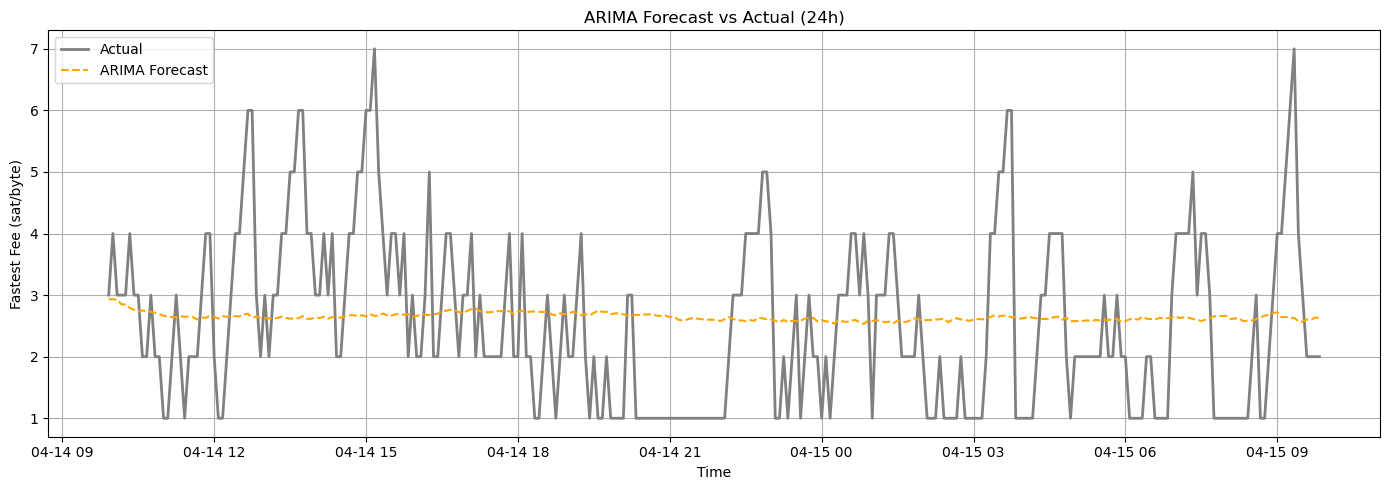

In [11]:

plt.figure(figsize=(14, 5))

# Plot actual values
plt.plot(y_test.index, y_test.values, label="Actual", linewidth=2, color = "grey")
# Plot predicted values
plt.plot(y_pred.index, y_pred.values, label="ARIMA Forecast", linestyle="--", color="orange")

plt.title("ARIMA Forecast vs Actual (24h)")
plt.xlabel("Time")
plt.ylabel("Fastest Fee (sat/byte)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
